In [1]:
import numpy as np
import pandas as pd
import math 
import random
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.svm import SVR
import joblib
import os
import copy
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.python.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from joblib import parallel_backend #启用多核并行计算
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
data = pd.read_csv('Electricity_load_of_Australia.csv')
data

,日期,小时,干球温度,露点温度,湿球温度,湿度,电价,电力负荷
0,2006/1/1,0.5,23.90,21.65,22.40,87.5,19.67,8013.27833
1,2006/1/1,1.0,23.90,21.70,22.40,88.0,18.56,7726.89167
2,2006/1/1,1.5,23.80,21.65,22.35,88.0,19.09,7372.85833
3,2006/1/1,2.0,23.70,21.60,22.30,88.0,17.40,7071.83333
4,2006/1/1,2.5,23.70,21.60,22.30,88.0,17.00,6865.44000
...,...,...,...,...,...,...,...,...
87643,2010/12/31,22.0,22.60,19.10,20.40,81.0,23.86,8449.54000
87644,2010/12/31,22.5,22.45,19.05,20.30,81.5,26.49,8508.16000
87645,2010/12/31,23.0,22.30,19.00,20.20,82.0,25.18,8413.14000
87646,2010/12/31,23.5,22.05,19.05,20.15,83.5,26.19,8173.79000


In [3]:
data['小时'] = data['小时'].apply(lambda x: x*2)
data['小时'] = data['小时'].astype(int)
data = data.rename(columns = {'日期': 'Date','小时': 'Period','干球温度': 'Dry-bulb temperature','露点温度': 'Dew point temperature',
                              '湿球温度': 'Wet-bulb temperature','湿度': 'Humidity','电价': 'Electricity price','电力负荷': 'Electricity load'})

In [4]:
#观察表中是否存在空值
data.isnull().sum()

Date                     0
Period                   0
Dry-bulb temperature     0
Dew point temperature    0
Wet-bulb temperature     0
Humidity                 0
Electricity price        0
Electricity load         0
dtype: int64

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data_copy = data.copy()

In [7]:
data = data.set_index('Date')

In [8]:
# 从时间变量中提取小时、天、工作日、所在月份信息
data_copy['Month'] = data_copy['Date'].dt.month # 提取所在月份
data_copy['Hour'] = data_copy['Date'].dt.hour # 提取所在小时
data_copy['Day'] = data_copy['Date'].dt.day # 提取所在天
data_copy['Weekday'] = data_copy['Date'].dt.dayofweek #提取所在工作日
data_copy.head(30)

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,Weekday
0,2006-01-01,1,23.90,21.65,22.40,87.5,19.67,8013.27833,1,0,1,6
1,2006-01-01,2,23.90,21.70,22.40,88.0,18.56,7726.89167,1,0,1,6
2,2006-01-01,3,23.80,21.65,22.35,88.0,19.09,7372.85833,1,0,1,6
3,2006-01-01,4,23.70,21.60,22.30,88.0,17.40,7071.83333,1,0,1,6
4,2006-01-01,5,23.70,21.60,22.30,88.0,17.00,6865.44000,1,0,1,6
5,2006-01-01,6,23.70,21.60,22.30,88.0,17.00,6685.92667,1,0,1,6
6,2006-01-01,7,23.60,21.65,22.30,89.0,17.00,6548.62833,1,0,1,6
7,2006-01-01,8,23.50,21.70,22.30,90.0,16.92,6487.83667,1,0,1,6
8,2006-01-01,9,23.50,21.70,22.30,90.0,15.20,6449.17833,1,0,1,6
9,2006-01-01,10,23.50,21.70,22.30,90.0,14.99,6388.27833,1,0,1,6


In [9]:
# 将所在星期几进行映射
data_copy['Weekday_Name'] = data_copy['Weekday']
replace_map = {'Weekday_Name': {0 :'Monday', 1 :'Tuesday', 2: 'Wednesday', 3:'Thursday', 4: 'Friday', 5 :'Saturday', 6: 'Sunday'}}
data_copy.replace(replace_map, inplace = True)
data_copy.head()

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,Weekday,Weekday_Name
0,2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,1,6,Sunday
1,2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,1,6,Sunday
2,2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,1,6,Sunday
3,2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,1,6,Sunday
4,2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,1,6,Sunday


In [10]:
# 展示是否是周末（在很多文献中，周末的电力负荷要小于工作日）
data_copy = data_copy.assign(Weekend = lambda df: df['Weekday'].apply(lambda day: 'Yes' if day >4 else 'No'))

In [11]:
# 将其转为0/1二值变量，1表示是周末，0表示不是周末
data_copy['Weekend_code'] = data_copy['Weekend']
replace_map = {'Weekend_code': {'No':0,'Yes':1}}
data_copy.replace(replace_map, inplace = True)
data_copy.head()

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code
0,2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,1,6,Sunday,Yes,1
1,2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,1,6,Sunday,Yes,1
2,2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,1,6,Sunday,Yes,1
3,2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,1,6,Sunday,Yes,1
4,2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,1,6,Sunday,Yes,1


In [12]:
# 干球温度是常说的温度
# 将2006年至2011年的干球温度变量进行group操作
month = data_copy.groupby('Month')
month_tmp = month['Dry-bulb temperature'].agg(['mean','min','max']).reset_index() # 按照均值、最小值、最大值进行聚合
month_tmp = pd.DataFrame(month_tmp)

month2 = data_copy.groupby('Month') 
month_el = month2['Electricity load'].agg(['mean','min','max']).reset_index()
month_el = pd.DataFrame(month_el) 

Text(0, 0.5, 'Electricity Load')

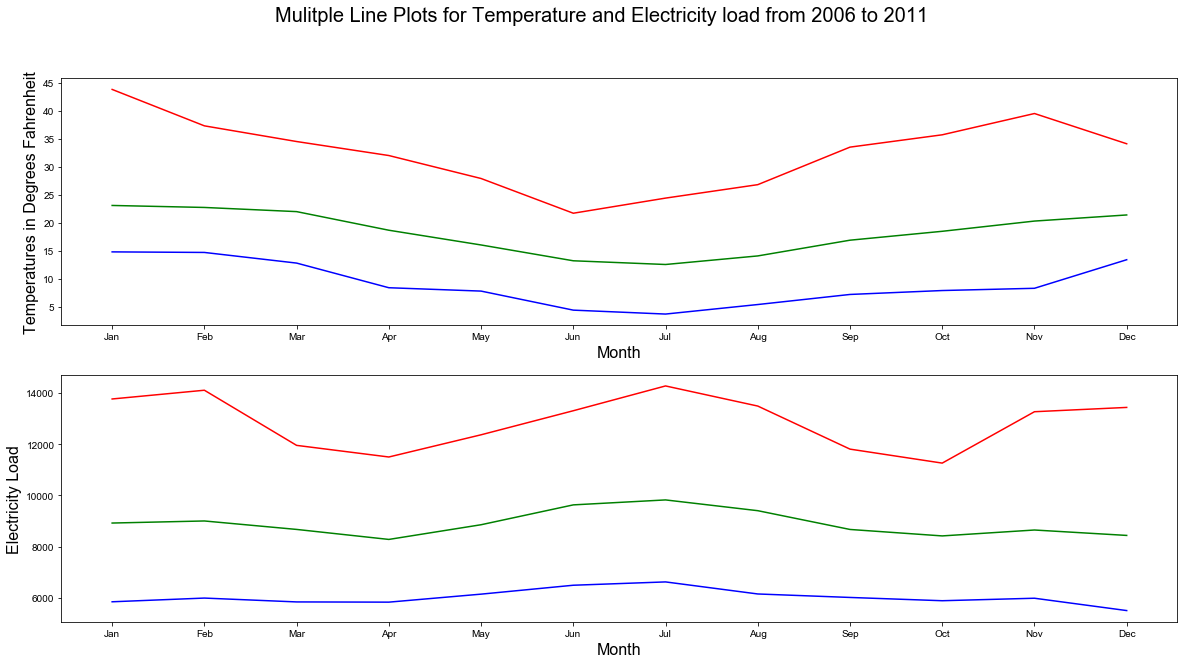

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10)) #创建子图
fig.suptitle('Mulitple Line Plots for Temperature and Electricity load from 2006 to 2011', fontsize=20) 
# 第一个折线图描述温度的均值、最大值、最小值变化
x1 = month_tmp.Month

y1 = month_tmp['mean']
y2 = month_tmp['min']
y3 = month_tmp['max']

axes[0].plot(x1, y1, label='Avg Temp', color='green') # 平均气温
axes[0].plot(x1, y2, label='Min Temp', color='blue') # 最小气温
axes[0].plot(x1, y3, label='Max Temp', color='red') # 最大气温
axes[0].set_xlabel('Month', fontsize=16)
axes[0].set_xticks(x1)
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].set_ylabel('Temperatures in Degrees Fahrenheit', fontsize=16)

# 第一个折线图描述电力负荷的均值、最大值、最小值变化
x2 = month_el.Month

y4 = month_el['mean']
y5 = month_el['min']
y6 = month_el['max']

axes[1].plot(x2, y4, label='Avg Temp', color='green') # 平均电力负荷
axes[1].plot(x2, y5, label='Min Temp', color='blue') # 最小电力负荷
axes[1].plot(x2, y6, label='Max Temp', color='red') # 最大电力负荷
axes[1].set_xlabel('Month', fontsize=16) 
axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].set_ylabel('Electricity Load', fontsize=16)

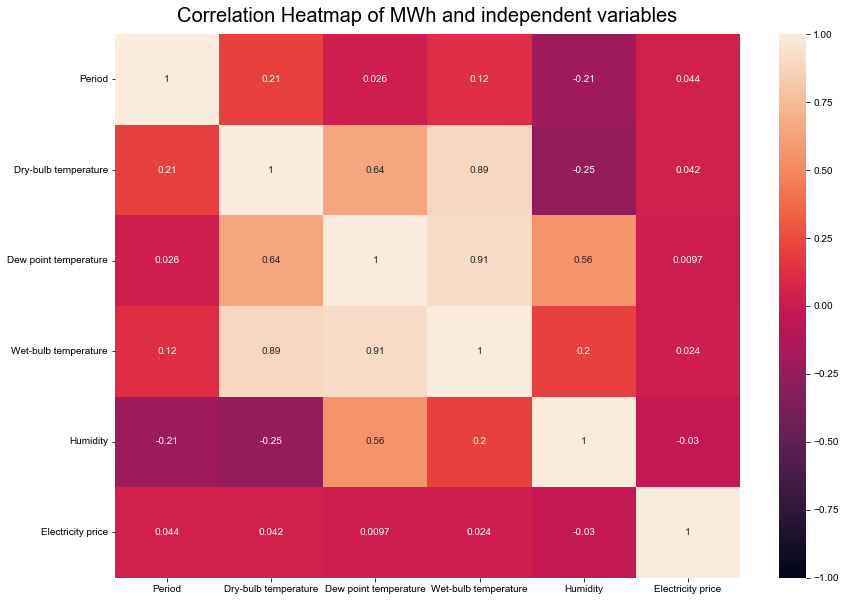

In [14]:
# 构造相关系数矩阵的热力图，将时间索引一列排除在外
data_corr = data_copy.iloc[:,0:7]

# 绘制相关系数的热力图
plt.figure(figsize=(14, 10)) #设置图片大小
heatmap = sns.heatmap(data_corr.corr(), vmin=-1, vmax=1, annot=True) # 可视化
heatmap.set_title('Correlation Heatmap of MWh and independent variables', fontdict={'fontsize':20}, pad=12)
plt.show() 

In [15]:
# 由于数据集为澳洲电力负荷数据，这里将定义澳洲在2010年的主要节日
Aus_holidays2010 = dict({
    1:{1: 'New Year Day',
       26: 'Australia Day'},
    3:{8: 'Canberra Day'},
    4:{4: 'Easter Day',
       25: 'ANZAC Day'},
    5:{26: 'Memorial Day'},
    6:{8: 'Queen’s Birthday'},
    10:{4: 'Labor Day'},
    11:{6: 'Cup Day',
        25: 'Thanksgiving Day'},
    12:{24: 'Christmas Eve',
        25: 'Christmas Day',
        26: 'Boxing Day'}
})

In [16]:
year2010 = data_copy.copy()
year2010['Year'] = year2010['Date'].dt.year # 提取2010年数据
year2010 = year2010[year2010['Year'] == 2010]
year2010 = year2010.assign(Event = lambda data: data['Date'].apply(lambda day: (Aus_holidays2010.get(day.month)).get(day.day)\
                                                if Aus_holidays2010.get(day.month) != None \
                                                and (Aus_holidays2010.get(day.month)).get(day.day) != None \
                                                else 'Normal'))

year2010

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,Year,Event
70127,2010-01-01,0,22.70,20.90,21.50,90.0,21.57,8038.00,1,0,1,4,Friday,No,0,2010,New Year Day
70128,2010-01-01,1,22.75,20.95,21.55,90.0,21.50,7809.31,1,0,1,4,Friday,No,0,2010,New Year Day
70129,2010-01-01,2,22.80,21.00,21.60,90.0,20.98,7483.69,1,0,1,4,Friday,No,0,2010,New Year Day
70130,2010-01-01,3,22.65,20.90,21.50,90.0,20.06,7117.23,1,0,1,4,Friday,No,0,2010,New Year Day
70131,2010-01-01,4,22.50,20.80,21.40,90.0,17.93,6812.03,1,0,1,4,Friday,No,0,2010,New Year Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87642,2010-12-31,43,22.70,19.20,20.50,81.0,25.68,8557.60,12,0,31,4,Friday,No,0,2010,Normal
87643,2010-12-31,44,22.60,19.10,20.40,81.0,23.86,8449.54,12,0,31,4,Friday,No,0,2010,Normal
87644,2010-12-31,45,22.45,19.05,20.30,81.5,26.49,8508.16,12,0,31,4,Friday,No,0,2010,Normal
87645,2010-12-31,46,22.30,19.00,20.20,82.0,25.18,8413.14,12,0,31,4,Friday,No,0,2010,Normal


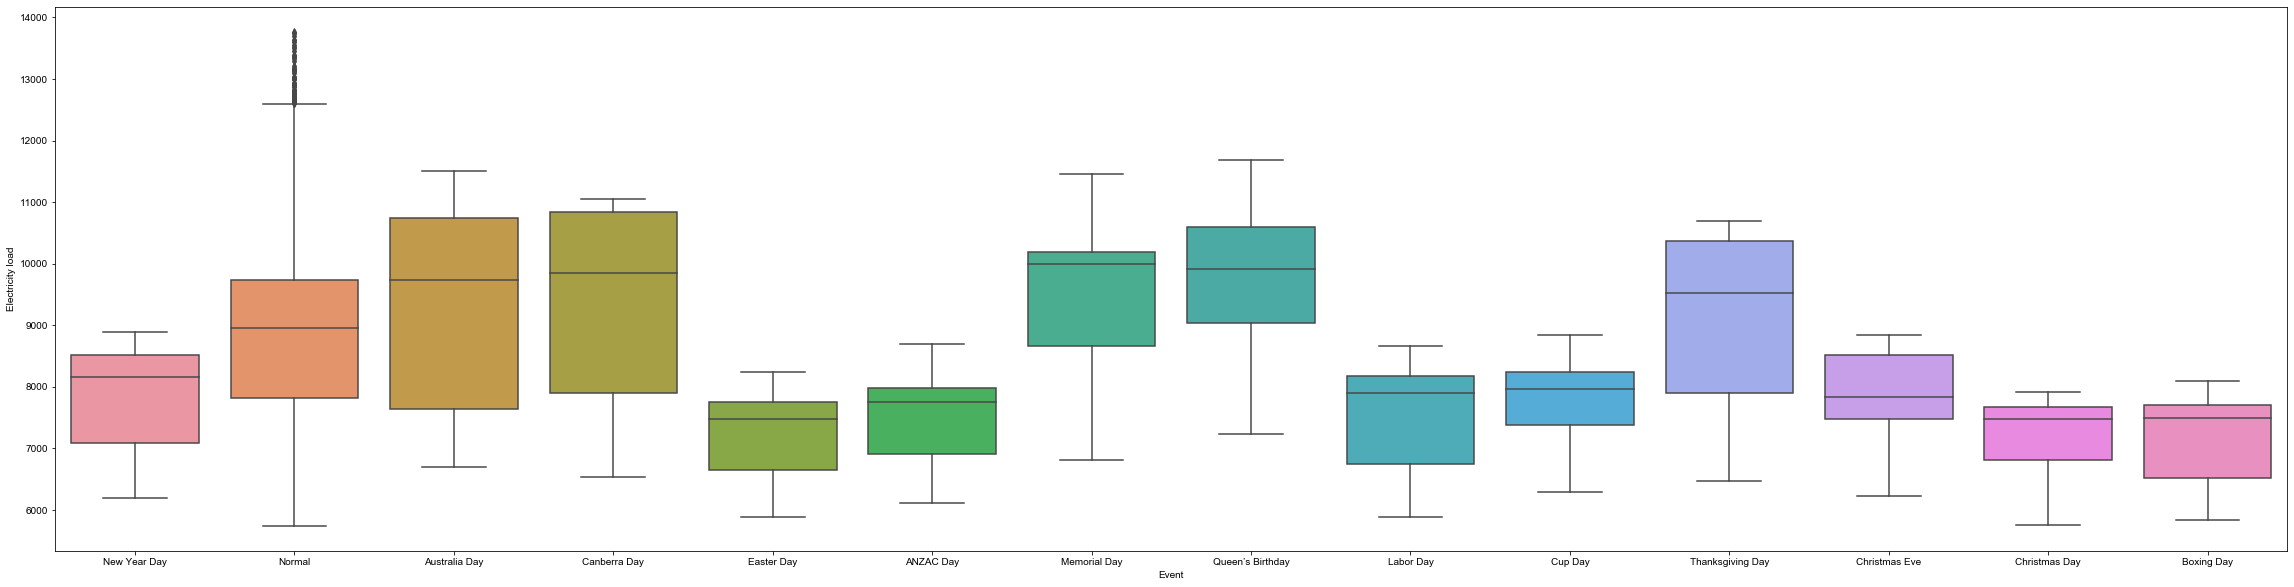

In [17]:
# 对假期和平时日的电力负荷情况进行可视化
plt.figure(figsize=(40,10))
plot3 = sns.boxplot(x="Event", y=year2010['Electricity load'], data=year2010, dodge=False)
plt.show()

In [18]:
august = data_copy[data_copy['Month'] == 8] # 取八月份的数据进行观察
day_info = august.groupby('Day').agg(['mean','min','max']).reset_index() # 按照均值、最小值、最大值进行聚合并设置为索引
day_info = pd.DataFrame(day_info) # 放入dataframe中
day_info = day_info.iloc[:,0:22] # 只包含目标变量以及数据集中的独立变量
day_info.head(31) 

Day                Date                       Period          \
                      mean        min        max   mean min max   
0    1 2008-07-31 14:24:00 2006-08-01 2010-08-01   23.5   0  47   
1    2 2008-08-01 14:24:00 2006-08-02 2010-08-02   23.5   0  47   
2    3 2008-08-02 14:24:00 2006-08-03 2010-08-03   23.5   0  47   
3    4 2008-08-03 14:24:00 2006-08-04 2010-08-04   23.5   0  47   
4    5 2008-08-04 14:24:00 2006-08-05 2010-08-05   23.5   0  47   
5    6 2008-08-05 14:24:00 2006-08-06 2010-08-06   23.5   0  47   
6    7 2008-08-06 14:24:00 2006-08-07 2010-08-07   23.5   0  47   
7    8 2008-08-07 14:24:00 2006-08-08 2010-08-08   23.5   0  47   
8    9 2008-08-08 14:24:00 2006-08-09 2010-08-09   23.5   0  47   
9   10 2008-08-09 14:24:00 2006-08-10 2010-08-10   23.5   0  47   
10  11 2008-08-10 14:24:00 2006-08-11 2010-08-11   23.5   0  47   
11  12 2008-08-11 14:24:00 2006-08-12 2010-08-12   23.5   0  47   
12  13 2008-08-12 14:24:00 2006-08-13 2010-08-13   23.5   0  47   
13  14 2008-08-13 14:24:00 2006-08-14 2010-08-14   23.5   0  47   
14  15 2008-08-14 14:24:00 2006-08-15 2010-08-15   23.5   0  47   
15  16 2008-08-15 14:24:00 2006-08-16 2010-08-16   23.5   0  47   
16  17 2008-08-16 14:24:00 2006-08-17 2010-08-17   23.5   0  47   
17  18 2008-08-17 14:24:00 2006-08-18 2010-08-18   23.5   0  47   
18  19 2008-08-18 14:24:00 2006-08-19 2010-08-19   23.5   0  47   
19  20 2008-08-19 14:24:00 2006-08-20 2010-08-20   23.5   0  47   
20  21 2008-08-20 14:24:00 2006-08-21 2010-08-21   23.5   0  47   
21  22 2008-08-21 14:24:00 2006-08-22 2010-08-22   23.5   0  47   
22  23 2008-08-22 14:24:00 2006-08-23 2010-08-23   23.5   0  47   
23  24 2008-08-23 14:24:00 2006-08-24 2010-08-24   23.5   0  47   
24  25 2008-08-24 14:24:00 2006-08-25 2010-08-25   23.5   0  47   
25  26 2008-08-25 14:24:00 2006-08-26 2010-08-26   23.5   0  47   
26  27 2008-08-26 14:24:00 2006-08-27 2010-08-27   23.5   0  47   
27  28 2008-08-27 14:24:00 2006-08-28 2010-08-28   23.5   0  47   
28  29 2008-08-28 14:24:00 2006-08-29 2010-08-29   23.5   0  47   
29  30 2008-08-29 14:24:00 2006-08-30 2010-08-30   23.5   0  47   
30  31 2008-08-30 14:24:00 2006-08-31 2010-08-31   23.5   0  47   

   Dry-bulb temperature             ... Dew point temperature  \
                   mean  min   max  ...                   max   
0             14.588958  9.2  23.7  ...                  8.10   
1             13.370000  8.0  21.6  ...                 12.40   
2             13.397083  7.0  20.4  ...                 11.20   
3             12.014167  8.2  18.7  ...                 13.60   
4             12.220000  6.8  18.6  ...                 12.20   
5             12.676458  7.9  18.9  ...                 10.10   
6             12.738333  6.8  23.2  ...                 11.50   
7             12.505417  6.5  22.2  ...                  8.10   
8             13.050625  5.9  22.8  ...                 10.20   
9             13.268958  6.8  22.5  ...                 14.80   
10            13.943958  7.2  25.0  ...                 13.30   
11            13.772500  6.9  21.0  ...                 12.90   
12            13.449167  8.6  20.6  ...                 10.70   
13            13.263542  7.0  21.5  ...                 12.00   
14            14.007917  8.8  22.1  ...                 11.30   
15            14.520625  9.3  25.5  ...                 14.10   
16            15.095833  7.2  25.3  ...                 12.00   
17            13.364792  5.7  21.9  ...                 12.15   
18            14.133542  5.4  24.3  ...                 12.80   
19            14.098958  8.2  20.6  ...                 13.00   
20            14.774375  9.1  24.8  ...                 11.05   
21            14.246875  8.6  24.6  ...                 11.30   
22            14.514167  7.4  24.9  ...                 13.10   
23            15.026875  5.7  23.7  ...                 13.00   
24            14.726875  8.3  20.2  ...                 12.90   
25            14.570625  8.7  23.6  

In [19]:
# 将2006年至2011年电力负荷一列按照一天中所在时段进行聚合
Period = data_copy.groupby('Period') # 按照所在时段进行聚合
Period_el = Period['Electricity load'].agg(['mean','min','max']).reset_index().sort_values('mean', ascending=False) 
Period_el.head(5) # 展示前五个

,Period,mean,min,max
37,37,10084.583354,6485.67,14240.04
36,36,10067.728458,6520.76,14274.15
38,38,10024.164109,6496.80,14064.82
39,39,9888.326028,6674.94,13731.37
35,35,9843.399921,6540.58,13630.90


In [20]:
data_copy['Dry-bulb temperature_5hr_roll_avg'] = data_copy.iloc[:,2].rolling(window=5).mean()
data_copy['Dew point temperature_5hr_roll_avg'] = data_copy.iloc[:,3].rolling(window=5).mean()
data_copy['Wet-bulb temperature_5hr_roll_avg'] = data_copy.iloc[:,4].rolling(window=5).mean()
data_copy['Humidity_5hr_roll_avg'] = data_copy.iloc[:,5].rolling(window=5).mean()
data_copy.head(6)

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,Dry-bulb temperature_5hr_roll_avg,Dew point temperature_5hr_roll_avg,Wet-bulb temperature_5hr_roll_avg,Humidity_5hr_roll_avg
0,2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,1,6,Sunday,Yes,1,NaN,NaN,NaN,NaN
1,2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,1,6,Sunday,Yes,1,NaN,NaN,NaN,NaN
2,2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,1,6,Sunday,Yes,1,NaN,NaN,NaN,NaN
3,2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,1,6,Sunday,Yes,1,NaN,NaN,NaN,NaN
4,2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,1,6,Sunday,Yes,1,23.80,21.64,22.35,87.9
5,2006-01-01,6,23.7,21.60,22.30,88.0,17.00,6685.92667,1,0,1,6,Sunday,Yes,1,23.76,21.63,22.33,88.0


In [21]:
data_copy['Dry-bulb temperature_10hr_roll_avg'] = data_copy.iloc[:,2].rolling(window=10).mean()
data_copy['Dew point temperature_10hr_roll_avg'] = data_copy.iloc[:,3].rolling(window=10).mean()
data_copy['Wet-bulb temperature_10hr_roll_avg'] = data_copy.iloc[:,4].rolling(window=10).mean()
data_copy['Humidity_10hr_roll_avg'] = data_copy.iloc[:,5].rolling(window=10).mean()
data_copy.head(6)

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,...,Weekend,Weekend_code,Dry-bulb temperature_5hr_roll_avg,Dew point temperature_5hr_roll_avg,Wet-bulb temperature_5hr_roll_avg,Humidity_5hr_roll_avg,Dry-bulb temperature_10hr_roll_avg,Dew point temperature_10hr_roll_avg,Wet-bulb temperature_10hr_roll_avg,Humidity_10hr_roll_avg
0,2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,...,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,...,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,...,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,...,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,...,Yes,1,23.80,21.64,22.35,87.9,NaN,NaN,NaN,NaN
5,2006-01-01,6,23.7,21.60,22.30,88.0,17.00,6685.92667,1,0,...,Yes,1,23.76,21.63,22.33,88.0,NaN,NaN,NaN,NaN


In [22]:
data_copy['Dry-bulb temperature_24hr_roll_avg'] = data_copy.iloc[:,2].rolling(window=24).mean()
data_copy['Dew point temperature_24hr_roll_avg'] = data_copy.iloc[:,3].rolling(window=24).mean()
data_copy['Wet-bulb temperature_24hr_roll_avg'] = data_copy.iloc[:,4].rolling(window=24).mean()
data_copy['Humidity_24hr_roll_avg'] = data_copy.iloc[:,5].rolling(window=24).mean()
data_copy.head(6)

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,...,Wet-bulb temperature_5hr_roll_avg,Humidity_5hr_roll_avg,Dry-bulb temperature_10hr_roll_avg,Dew point temperature_10hr_roll_avg,Wet-bulb temperature_10hr_roll_avg,Humidity_10hr_roll_avg,Dry-bulb temperature_24hr_roll_avg,Dew point temperature_24hr_roll_avg,Wet-bulb temperature_24hr_roll_avg,Humidity_24hr_roll_avg
0,2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,...,22.35,87.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2006-01-01,6,23.7,21.60,22.30,88.0,17.00,6685.92667,1,0,...,22.33,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data_copy['Dry-bulb temperature_48hr_roll_avg'] = data_copy.iloc[:,2].rolling(window=48).mean()
data_copy['Dew point temperature_48hr_roll_avg'] = data_copy.iloc[:,3].rolling(window=48).mean()
data_copy['Wet-bulb temperature_48hr_roll_avg'] = data_copy.iloc[:,4].rolling(window=48).mean()
data_copy['Humidity_48hr_roll_avg'] = data_copy.iloc[:,5].rolling(window=48).mean()
data_copy.head(6)

,Date,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,...,Wet-bulb temperature_10hr_roll_avg,Humidity_10hr_roll_avg,Dry-bulb temperature_24hr_roll_avg,Dew point temperature_24hr_roll_avg,Wet-bulb temperature_24hr_roll_avg,Humidity_24hr_roll_avg,Dry-bulb temperature_48hr_roll_avg,Dew point temperature_48hr_roll_avg,Wet-bulb temperature_48hr_roll_avg,Humidity_48hr_roll_avg
0,2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2006-01-01,6,23.7,21.60,22.30,88.0,17.00,6685.92667,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#前四年的数据用作训练集
target_t_sampled = data_copy[data_copy.Date.between('2006-01-01', '2010-01-01')]
target_t_sampled = target_t_sampled.set_index('Date')
target_t_sampled.head()

,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,...,Wet-bulb temperature_10hr_roll_avg,Humidity_10hr_roll_avg,Dry-bulb temperature_24hr_roll_avg,Dew point temperature_24hr_roll_avg,Wet-bulb temperature_24hr_roll_avg,Humidity_24hr_roll_avg,Dry-bulb temperature_48hr_roll_avg,Dew point temperature_48hr_roll_avg,Wet-bulb temperature_48hr_roll_avg,Humidity_48hr_roll_avg
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,1,23.9,21.65,22.40,87.5,19.67,8013.27833,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-01,2,23.9,21.70,22.40,88.0,18.56,7726.89167,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-01,3,23.8,21.65,22.35,88.0,19.09,7372.85833,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-01,4,23.7,21.60,22.30,88.0,17.40,7071.83333,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-01,5,23.7,21.60,22.30,88.0,17.00,6865.44000,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#将2010年数据用作测试集，前四年的数据用作训练集
target_e_sampled = data_copy[data_copy.Date.between('2010-01-01', '2011-01-01')]
target_e_sampled = target_e_sampled.set_index('Date')
target_e_sampled.head()

,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Electricity load,Month,Hour,Day,...,Wet-bulb temperature_10hr_roll_avg,Humidity_10hr_roll_avg,Dry-bulb temperature_24hr_roll_avg,Dew point temperature_24hr_roll_avg,Wet-bulb temperature_24hr_roll_avg,Humidity_24hr_roll_avg,Dry-bulb temperature_48hr_roll_avg,Dew point temperature_48hr_roll_avg,Wet-bulb temperature_48hr_roll_avg,Humidity_48hr_roll_avg
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,22.70,20.90,21.50,90.0,21.57,8038.00,1,0,1,...,21.535,86.55,23.485417,20.256250,21.404167,82.208333,22.545833,19.279167,20.475000,82.052083
2010-01-01,1,22.75,20.95,21.55,90.0,21.50,7809.31,1,0,1,...,21.535,86.90,23.464583,20.314583,21.431250,82.645833,22.571875,19.368750,20.537500,82.385417
2010-01-01,2,22.80,21.00,21.60,90.0,20.98,7483.69,1,0,1,...,21.525,87.10,23.443750,20.377083,21.460417,83.104167,22.598958,19.464583,20.604167,82.739583
2010-01-01,3,22.65,20.90,21.50,90.0,20.06,7117.23,1,0,1,...,21.515,87.50,23.416667,20.425000,21.479167,83.500000,22.622917,19.560417,20.669792,83.104167
2010-01-01,4,22.50,20.80,21.40,90.0,17.93,6812.03,1,0,1,...,21.505,88.10,23.383333,20.458333,21.487500,83.833333,22.643750,19.656250,20.734375,83.479167


In [26]:
X_train = target_t_sampled.iloc[:,[0,1,2,3,4,5,7,9,10,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]
print(X_train.shape)

y_train = target_t_sampled['Electricity load']
print(y_train.shape)

(70175, 26)
(70175,)


In [27]:
X_test = target_e_sampled.iloc[:,[0,1,2,3,4,5,7,9,10,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]
print(X_test.shape)

y_test = target_e_sampled['Electricity load']
print(y_test.shape)

(17521, 26)
(17521,)


In [28]:
data_copy = data_copy.set_index('Date')

In [29]:
data_copy.isnull().sum()

Period                                  0
Dry-bulb temperature                    0
Dew point temperature                   0
Wet-bulb temperature                    0
Humidity                                0
Electricity price                       0
Electricity load                        0
Month                                   0
Hour                                    0
Day                                     0
Weekday                                 0
Weekday_Name                            0
Weekend                                 0
Weekend_code                            0
Dry-bulb temperature_5hr_roll_avg       4
Dew point temperature_5hr_roll_avg      4
Wet-bulb temperature_5hr_roll_avg       4
Humidity_5hr_roll_avg                   4
Dry-bulb temperature_10hr_roll_avg      9
Dew point temperature_10hr_roll_avg     9
Wet-bulb temperature_10hr_roll_avg      9
Humidity_10hr_roll_avg                  9
Dry-bulb temperature_24hr_roll_avg     23
Dew point temperature_24hr_roll_av

In [30]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
print(df_train.shape, df_test.shape)

(70175, 27) (17521, 27)


In [31]:
#fill missing values with ffill and bfill
df_train = df_train.fillna(method='ffill').fillna(method='bfill')
df_train.head()

,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Month,Day,Weekday,Weekend_code,...,Humidity_10hr_roll_avg,Dry-bulb temperature_24hr_roll_avg,Dew point temperature_24hr_roll_avg,Wet-bulb temperature_24hr_roll_avg,Humidity_24hr_roll_avg,Dry-bulb temperature_48hr_roll_avg,Dew point temperature_48hr_roll_avg,Wet-bulb temperature_48hr_roll_avg,Humidity_48hr_roll_avg,Electricity load
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,1,23.9,21.65,22.40,87.5,19.67,1,1,6,1,...,88.65,28.94375,19.29375,22.845833,65.75,32.582292,17.016667,22.85,50.78125,8013.27833
2006-01-01,2,23.9,21.70,22.40,88.0,18.56,1,1,6,1,...,88.65,28.94375,19.29375,22.845833,65.75,32.582292,17.016667,22.85,50.78125,7726.89167
2006-01-01,3,23.8,21.65,22.35,88.0,19.09,1,1,6,1,...,88.65,28.94375,19.29375,22.845833,65.75,32.582292,17.016667,22.85,50.78125,7372.85833
2006-01-01,4,23.7,21.60,22.30,88.0,17.40,1,1,6,1,...,88.65,28.94375,19.29375,22.845833,65.75,32.582292,17.016667,22.85,50.78125,7071.83333
2006-01-01,5,23.7,21.60,22.30,88.0,17.00,1,1,6,1,...,88.65,28.94375,19.29375,22.845833,65.75,32.582292,17.016667,22.85,50.78125,6865.44000


In [32]:
X1 = df_train.iloc[:,0:26]
y1 = df_train['Electricity load']

In [33]:
#fill missing values with ffill and bfill
df_test = df_test.fillna(method='ffill').fillna(method='bfill')
df_test.head()

,Period,Dry-bulb temperature,Dew point temperature,Wet-bulb temperature,Humidity,Electricity price,Month,Day,Weekday,Weekend_code,...,Humidity_10hr_roll_avg,Dry-bulb temperature_24hr_roll_avg,Dew point temperature_24hr_roll_avg,Wet-bulb temperature_24hr_roll_avg,Humidity_24hr_roll_avg,Dry-bulb temperature_48hr_roll_avg,Dew point temperature_48hr_roll_avg,Wet-bulb temperature_48hr_roll_avg,Humidity_48hr_roll_avg,Electricity load
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,22.70,20.90,21.50,90.0,21.57,1,1,4,0,...,86.55,23.485417,20.256250,21.404167,82.208333,22.545833,19.279167,20.475000,82.052083,8038.00
2010-01-01,1,22.75,20.95,21.55,90.0,21.50,1,1,4,0,...,86.90,23.464583,20.314583,21.431250,82.645833,22.571875,19.368750,20.537500,82.385417,7809.31
2010-01-01,2,22.80,21.00,21.60,90.0,20.98,1,1,4,0,...,87.10,23.443750,20.377083,21.460417,83.104167,22.598958,19.464583,20.604167,82.739583,7483.69
2010-01-01,3,22.65,20.90,21.50,90.0,20.06,1,1,4,0,...,87.50,23.416667,20.425000,21.479167,83.500000,22.622917,19.560417,20.669792,83.104167,7117.23
2010-01-01,4,22.50,20.80,21.40,90.0,17.93,1,1,4,0,...,88.10,23.383333,20.458333,21.487500,83.833333,22.643750,19.656250,20.734375,83.479167,6812.03


In [34]:
X2 = df_test.iloc[:,0:26]
y2 = df_test['Electricity load']

## ---------------------------------数据归一化处理---------------------------------

In [35]:
#自定义归一化处理函数
def normalization(data):
    newDataFrame = pd.DataFrame(index=data.index)
    columns = data.columns.tolist()
    for c in columns:
        d = data[c]
        MAX = d.max()
        MIN = d.min()
        newDataFrame[c] = ((d - MIN) / (MAX - MIN)).tolist()
    return newDataFrame

In [36]:
Train_X_Normalization = normalization(X1)
MAX_y1 = y1.max()
MIN_y1 = y1.min()
Train_Y_Normalization = (y1 - MIN_y1) / (MAX_y1 - MIN_y1)

In [37]:
Test_X_Normalization = normalization(X2)
MAX_y2 = y2.max()
MIN_y2 = y2.min()
Test_Y_Normalization = (y2 - MIN_y2) / (MAX_y2 - MIN_y2)

## ---------------------------------极端随机树特征筛选---------------------------------

In [38]:
ET_Regression = ExtraTreesRegressor(random_state=1234)  #极度随机树分类器
ET_Regression.fit(Train_X_Normalization,y1)
Predict_ET = ET_Regression.predict(Test_X_Normalization)

In [39]:
feature_names = ['时段','干球温度','露点温度','湿球温度','湿度','电价','月份','日期','工作日','是否为周末','干球温度-5小时滑动平均',
                '露点温度-5小时滑动平均','湿球温度-5小时滑动平均','湿度-5小时滑动平均','干球温度-10小时滑动平均',
                '露点温度-10小时滑动平均','湿球温度-10小时滑动平均','湿度-10小时滑动平均','干球温度-24小时滑动平均',
                '露点温度-24小时滑动平均','湿球温度-24小时滑动平均','湿度-24小时滑动平均','干球温度-48小时滑动平均',
                '露点温度-48小时滑动平均','湿球温度-48小时滑动平均','湿度-48小时滑动平均']

Feature: 0, Score: 0.55557
Feature: 1, Score: 0.03224
Feature: 2, Score: 0.00286
Feature: 3, Score: 0.01450
Feature: 4, Score: 0.01607
Feature: 5, Score: 0.03123
Feature: 6, Score: 0.02592
Feature: 7, Score: 0.00884
Feature: 8, Score: 0.02046
Feature: 9, Score: 0.07425
Feature: 10, Score: 0.02923
Feature: 11, Score: 0.00273
Feature: 12, Score: 0.01458
Feature: 13, Score: 0.00984
Feature: 14, Score: 0.01938
Feature: 15, Score: 0.00259
Feature: 16, Score: 0.01254
Feature: 17, Score: 0.00280
Feature: 18, Score: 0.02222
Feature: 19, Score: 0.00329
Feature: 20, Score: 0.01118
Feature: 21, Score: 0.00318
Feature: 22, Score: 0.05404
Feature: 23, Score: 0.00391
Feature: 24, Score: 0.02215
Feature: 25, Score: 0.00441


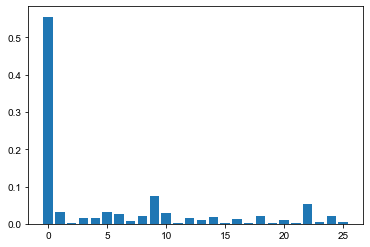

In [40]:
ET_importance = ET_Regression.feature_importances_
for i,v in enumerate(ET_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(ET_importance))], ET_importance)
plt.show()

In [41]:
feature_names = np.array(feature_names)
index_sorted = np.flipud(np.argsort(-ET_importance))
pos = np.arange(index_sorted.shape[0])

In [42]:
#绘图。
plt.figure(dpi=1080,figsize=(16,10))
plt.barh(range(len(feature_names)), ET_importance[index_sorted])
 
#设置Y轴纵坐标上的刻度线标签。
plt.yticks(pos,feature_names[index_sorted],rotation=360,fontsize= 12)
plt.xlabel('变量重要性比例', fontsize='10',fontweight='bold', color='black')
plt.title('极端随机树特征重要性分析结果',fontsize='15',fontweight='bold', color='black')

plt.savefig("ET.jpg", dpi=750, bbox_inches = 'tight') 
plt.show()

In [43]:
# Fit model using each importance as a threshold
thresholds = sort(ET_importance)
print(thresholds)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(ET_Regression, threshold=thresh, prefit=True)
    select_X_train = selection.transform(Train_X_Normalization)
    # train model
    selection_model = ExtraTreesRegressor(random_state=1234) 
    selection_model.fit(select_X_train, y1)
    # eval model    
    select_X_test = selection.transform(Test_X_Normalization)

    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    MAE = mean_absolute_error(y2, predictions)
    RMSE = sqrt(mean_squared_error(y2, predictions))
    R2 = r2_score(y2, predictions)
    print("Thresh=%.3f, n=%d, MAE: %.2f, RMSE: %.2f, R2: %.2f" % (thresh, select_X_train.shape[1], MAE, RMSE, R2))

[0.00258909 0.00272556 0.00279528 0.00286428 0.0031817  0.00328899
 0.00390867 0.00440884 0.00883631 0.00983854 0.011181   0.01254058
 0.01449959 0.01457671 0.01607366 0.01937788 0.02046241 0.0221483
 0.02222416 0.02592252 0.02922798 0.03122595 0.03223972 0.05403734
 0.07425131 0.55557365]
Thresh=0.003, n=26, MAE: 530.94, RMSE: 710.63, R2: 0.73
Thresh=0.003, n=25, MAE: 537.90, RMSE: 713.01, R2: 0.73
Thresh=0.003, n=24, MAE: 532.18, RMSE: 707.77, R2: 0.73
Thresh=0.003, n=23, MAE: 535.47, RMSE: 716.82, R2: 0.73
Thresh=0.003, n=22, MAE: 545.62, RMSE: 724.97, R2: 0.72
Thresh=0.003, n=21, MAE: 546.73, RMSE: 724.17, R2: 0.72
Thresh=0.004, n=20, MAE: 551.13, RMSE: 730.51, R2: 0.72
Thresh=0.004, n=19, MAE: 548.47, RMSE: 729.35, R2: 0.72
Thresh=0.009, n=18, MAE: 545.06, RMSE: 723.23, R2: 0.72
Thresh=0.010, n=17, MAE: 570.63, RMSE: 750.56, R2: 0.70
Thresh=0.011, n=16, MAE: 561.25, RMSE: 751.72, R2: 0.70
Thresh=0.013, n=15, MAE: 572.96, RMSE: 758.56, R2: 0.70
Thresh=0.014, n=14, MAE: 575.71, RMSE

In [44]:
RMSE_ET = sqrt(mean_squared_error(y_true=y2,y_pred=Predict_ET))
MAE_ET = mean_absolute_error(y_true=y2,y_pred=Predict_ET)
print('RMSE:', RMSE_ET)
print('MAE', MAE_ET)
print("r2 score:", r2_score(y2, Predict_ET)) 

RMSE: 710.6330891574601
MAE 530.9373796107412
r2 score: 0.7324679575485582


## ---------------------------------LSTM回归预测模型---------------------------------

In [38]:
X_train = X_train.iloc[:,[0,1,9,10,22]]
X_test = X_test.iloc[:,[0,1,9,10,22]]

In [39]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
print(X_train.shape, X_test.shape)

(70175, 5) (17521, 5)


In [40]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(0,len(sequences)): 
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [41]:
# save everything as a dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# reset the index on everything
# issue with dates and integers
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

# put X_train and y_train together 
# put X_test and y_test together 
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
print(df_train.shape, df_test.shape)

(70175, 6) (17521, 6)


In [42]:
#fill missing values with ffill and bfill
df_train = df_train.fillna(method='ffill').fillna(method='bfill')
df_train.head()

,0,1,2,3,4,Electricity load
0,0.021277,0.503741,1.0,0.497602,1.0,8013.27833
1,0.042553,0.503741,1.0,0.497602,1.0,7726.89167
2,0.063830,0.501247,1.0,0.497602,1.0,7372.85833
3,0.085106,0.498753,1.0,0.497602,1.0,7071.83333
4,0.106383,0.498753,1.0,0.497602,1.0,6865.44000


In [43]:
#fill missing values with ffill and bfill
df_test = df_test.fillna(method='ffill').fillna(method='bfill')
df_test.head()

,0,1,2,3,4,Electricity load
0,0.000000,0.473815,0.0,0.476900,0.589563,8038.00
1,0.021277,0.475062,0.0,0.473113,0.590628,7809.31
2,0.042553,0.476309,0.0,0.471346,0.591736,7483.69
3,0.063830,0.472569,0.0,0.470588,0.592716,7117.23
4,0.085106,0.468828,0.0,0.469326,0.593568,6812.03


In [44]:
#lookback period of 30
n_steps = 30
#applying split_sequence function on df_train to get X_train and y_train
X_train, y_train = split_sequences(np.array(df_train), n_steps)
#applying split_sequence function on df_test to get X_test and y_test
X_test, y_test = split_sequences(np.array(df_test), n_steps)
# check the shape for X_train and y_train
print(X_train.shape, y_train.shape)
# check the shape for X_test and y_test
print(X_test.shape, y_test.shape) 

(70146, 30, 5) (70146,)
(17492, 30, 5) (17492,)


In [45]:
#assign n_steps and n_features
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

## ------------------------PSO-Bi-LSTM回归预测模型-------------------------

In [46]:
def build_model(neurons, dropout):
    model = Sequential([
        layers.Conv1D(filters=20, kernel_size=2, input_shape=(n_steps,n_features)),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=10, kernel_size=2),
        layers.MaxPooling1D(2),
        layers.Bidirectional(LSTM(units = neurons,return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(GRU(75, return_sequences=True )),
        layers.Dropout(dropout),
        layers.SimpleRNN(50, activation = 'relu'),
        layers.Dropout(dropout),
        layers.Dense(40, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='linear')    # 因为只有一个特征值的输出
    ])
    return model


def training(X):
    neurons = int(X[0])
    dropout = round(X[1], 6)
    batch_size = int(X[2])
    model = build_model(neurons, dropout)
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=256,
        validation_data=(X_test, y_test),
        verbose=1,shuffle=True)
    model.save(
        'neurons' + str(int(X[0])) + '_dropout' + str(dropout) + '_batch_size' + str(batch_size) + '.h5')

    pred = model.predict(X_test)
    le = len(pred)
    y_t = y_test.reshape(-1, 1)
    return pred, le, y_t


def function(ps, test, le):
    ss = sum(((abs(test - ps)) / test) / le)
    return ss

#前两个设置为2
# (1) PSO Parameters
MAX_EPISODES = 2
MAX_EP_STEPS = 2
c1 = 1
c2 = 1
w = 0.5
pN = 1  # 粒子数量

# (2) LSTM Parameters
dim = 3  # 搜索维度
X = np.zeros((pN, dim))  # 所有粒子的位置和速度
V = np.zeros((pN, dim))
pbest = np.zeros((pN, dim))  # 个体经历的最佳位置和全局最佳位置
gbest = np.zeros(dim)
p_fit = np.zeros(pN)  # 每个个体的历史最佳适应值
print(p_fit.shape)
print(p_fit.shape)
t1 = time.time()

'''
神经网络第一层神经元个数： 256-259
dropout比率： 0.03-0.19
batch_size： 64-128
'''
UP = [259, 0.19, 128]
DOWN = [256, 0.03, 64]

# (4) 开始搜索
for i_episode in range(MAX_EPISODES):
    """初始化s"""
    fit = -1e5  # 全局最佳适应值
    # 初始粒子适应度计算
    print("计算初始全局最优")
    for i in range(pN):
        for j in range(dim):
            V[i][j] = random.uniform(0, 1)
            if j == 1:
                X[i][j] = random.uniform(DOWN[j], UP[j])
            else:
                X[i][j] = round(random.randint(DOWN[j], UP[j]), 0)
        pbest[i] = X[i]
        le, pred, y_t = training(X[i])
        NN = 1
        tmp = function(pred, y_t, le)
        p_fit[i] = tmp
        if tmp > fit:
            fit = tmp
            gbest = X[i]
    print("初始全局最优参数：{:}".format(gbest))

    fitness = []  # 适应度函数
    for j in range(MAX_EP_STEPS):
        fit2 = []
        plt.title("第{}次迭代".format(i_episode))
        for i in range(pN):
            le, pred, y_t = training(X[i])
            temp = function(pred, y_t, le)
            fit2.append(temp / 1000)
            if temp > p_fit[i]:  # 更新个体最优
                p_fit[i] = temp
                pbest[i] = X[i]
                if p_fit[i] > fit:  # 更新全局最优
                    gbest = X[i]
                    fit = p_fit[i]
        print("搜索步数：{:}".format(j))
        print("个体最优参数：{:}".format(pbest))
        print("全局最优参数：{:}".format(gbest))
            # [30.          0.14277071 95.        ]
        for i in range(pN):
            V[i] = w * V[i] + c1 * random.uniform(0, 1) * (pbest[i] - X[i]) + c2 * random.uniform(0, 1) * (gbest - X[i])
            ww = 1
            for k in range(dim):
                if DOWN[k] < X[i][k] + V[i][k] < UP[k]:
                    continue
                else:
                    ww = 0
            X[i] = X[i] + V[i] * ww
        fitness.append(fit)

print('Running time: ', time.time() - t1)


(1,)
(1,)
计算初始全局最优
Metal device set to: Apple M1 Pro


2022-06-13 12:26:17.088642: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 12:26:17.088779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-13 12:26:17.489214: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-13 12:26:17.489381: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/256


2022-06-13 12:26:18.864471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:26:19.170558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:26:19.180702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:26:19.242725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:26:19.251413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:26:19.423321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:26:19.438163: I tensorflow/core/grappler/optimizers/cust

 138/1063 [==>...........................] - ETA: 1:05 - loss: 28400180.0000 - mae: 4109.1768

KeyboardInterrupt: 

In [50]:
# PSO优化Bi-LSTM所得参数：2.56000000e+02 6.77152943e-02 9.90000000e+01
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

neurons = int(2.56000000e+02)
dropout = 6.77152943e-02
batch_size = int(9.90000000e+01)
model_PSO_BiLSTM = build_model(neurons, dropout)
model_PSO_BiLSTM.compile(optimizer='adam',loss='mse',metrics=['mae'])
model_PSO_BiLSTM.summary()

history = model_PSO_BiLSTM.fit(X_train, y_train,callbacks = [es],epochs=256,batch_size=batch_size,validation_data=(X_test, y_test),verbose=1,shuffle=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 29, 20)            220       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 14, 20)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 13, 10)            410       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 6, 10)             0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 6, 512)            546816    
_________________________________________________________________
dropout_32 (Dropout)         (None, 6, 512)            0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 6, 150)           

2022-06-09 09:12:28.150783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:12:28.497839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:12:28.507991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:12:28.618782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:12:28.627019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:12:29.047779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:12:29.064138: I tensorflow/core/grappler/optimizers/cust

709/709 [==============================] - ETA: 0s - loss: 6981065.5000 - mae: 1734.3063

2022-06-09 09:13:19.981421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:13:20.089386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:13:20.095865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:13:20.169004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 09:13:20.174573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


709/709 [==============================] - 59s 77ms/step - loss: 6981065.5000 - mae: 1734.3063 - val_loss: 706287.6250 - val_mae: 645.4756
Epoch 2/256
709/709 [==============================] - 53s 74ms/step - loss: 644488.3750 - mae: 599.2602 - val_loss: 339340.3438 - val_mae: 415.2632
Epoch 3/256
709/709 [==============================] - 52s 74ms/step - loss: 357879.4062 - mae: 438.6349 - val_loss: 253602.8125 - val_mae: 379.0490
Epoch 4/256
709/709 [==============================] - 53s 74ms/step - loss: 293080.3125 - mae: 393.4289 - val_loss: 292330.7188 - val_mae: 400.4992
Epoch 5/256
709/709 [==============================] - 53s 74ms/step - loss: 284380.4062 - mae: 386.6280 - val_loss: 246345.7969 - val_mae: 370.7735
Epoch 6/256
709/709 [==============================] - 53s 74ms/step - loss: 275650.5938 - mae: 380.7727 - val_loss: 221828.5469 - val_mae: 342.4160
Epoch 7/256
709/709 [==============================] - 53s 74ms/step - loss: 262010.6875 - mae: 369.1497 - val_loss:

In [51]:
#保存训练的模型
model_PSO_BiLSTM.save('model_PSO_BiLSTM.h5')

In [52]:
#加载训练过的模型
model_PSO_BiLSTM = keras.models.load_model('model_PSO_BiLSTM.h5')

In [53]:
# make a prediction for train data
pred = model_PSO_BiLSTM.predict(X_train)
pred = np.round(pred,0)

2022-06-09 10:01:31.427488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 10:01:31.533073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 10:01:31.540580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 10:01:31.633897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 10:01:31.639930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [54]:
#print the lowest train MAE for the model
print('Lowest Train MAE: ', mean_absolute_error(y_train, pred))

Lowest Train MAE:  317.6404469931286


In [55]:
# make a prediction
pred = model_PSO_BiLSTM.predict(X_test)
pred = np.round(pred,0)

In [56]:
#print the lowest MAE for the model
print('Lowest Test MAE: ', mean_absolute_error(y_test, pred))

Lowest Test MAE:  291.681425794649


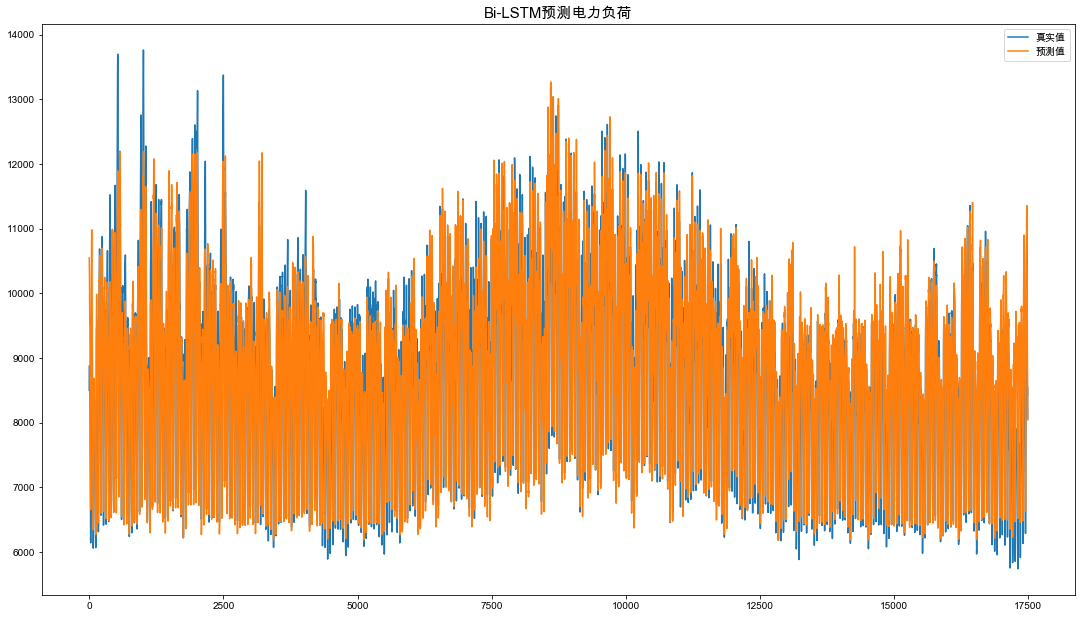

In [57]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]),y_test)#测试数组
plt.plot(np.arange(X_test.shape[0]),pred)#测试数组
plt.legend(['真实值','预测值'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("Bi-LSTM预测电力负荷", fontsize='15',fontweight='bold', color='black')  # 标题
plt.show()

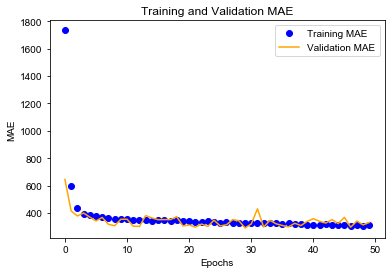

In [58]:
# plotting the graph to see the training and validation loss by epoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae)) #number of epochs
#plotting training and validation MAE
# "bo" is for "blue dot"
plt.plot(epochs, mae, 'bo', label='Training MAE')
# orange is for "solid orange line"
plt.plot(epochs, val_mae, 'orange', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

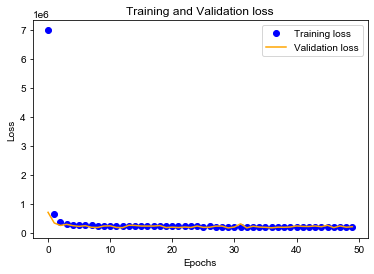

In [59]:
plt.figure()
#plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [60]:
print("mean_absolute_error:", mean_absolute_error(y_test, pred))  
print("rmse:", sqrt(mean_squared_error(y_test, pred)))
print("r2 score:", r2_score(y_test, pred))  

mean_absolute_error: 291.681425794649
rmse: 410.96735883266643
r2 score: 0.910451503345062


## ------------------PSO-Bi-LSTM回归预测模型-神经元参数变化---------------------

In [52]:
model = Sequential()
#Convolution 1D layer with 20 filters and input shape = (30,16)
model.add(Conv1D(filters=20, kernel_size=2, input_shape=(n_steps,n_features))) 
#Maxpooling 1D layer with filter size = 2
model.add(MaxPooling1D(2))
#Convolution 1D layer with 10 filters
model.add(Conv1D(filters=10, kernel_size=2,))
#Maxpooling 1D layer with filter size = 2
model.add(MaxPooling1D(2))
#Bidirectional LSTM layer with 100 hidden units
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Dropout(0.2))
#Bidirectional GRU layer with 75 hidden units
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
#SimpleRNN layer with 50 hidden units
model.add(SimpleRNN(32, activation='relu'))
model.add(Dropout(0.2))
#Dense Layer 1 with 40 hidden units
model.add(Dense(40, activation='relu'))
#Dense Layer 2 with 30 hidden units
model.add(Dense(30, activation='relu'))
#Dense Layer 3 with 20 hidden units
model.add(Dense(20, activation='relu'))
#Dense Layer 4 with 10 hidden units
model.add(Dense(10, activation='relu'))
#Dropout function with 0.1 probability
model.add(Dropout(0.1))
#Output layer with activation function 'linear' as it is a regression problem
model.add(Dense(1, activation='linear'))
#compile the model using 'adam' optimizer
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
#Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 29, 20)            220       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 13, 10)            410       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 10)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6, 512)            546816    
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 512)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 6, 512)           

In [53]:
begin_time = time.time()
# early stopping with a patience of 20
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

# fit the model with 10 epochs
history = model.fit(X_train, y_train,
                    callbacks=[es],
                    epochs=256,
                    batch_size=100,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    shuffle=True)

end_time = time.time()

print('Total time: {} s'.format(int(end_time-begin_time)))

Epoch 1/256


2022-06-10 09:23:18.667042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.040552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.050267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.105968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.115963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.168237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.175965: I tensorflow/core/grappler/optimizers/cust

  1/702 [..............................] - ETA: 35:19 - loss: 80455496.0000 - mae: 8852.0908

2022-06-10 09:23:19.644183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:23:19.660752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


702/702 [==============================] - ETA: 0s - loss: 7580288.5000 - mae: 1621.8778

2022-06-10 09:24:21.791107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:24:21.903630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:24:21.910026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:24:21.961058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:24:21.967456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:24:22.019163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:24:22.025481: I tensorflow/core/grappler/optimizers/cust

702/702 [==============================] - 70s 96ms/step - loss: 7580288.5000 - mae: 1621.8778 - val_loss: 908715.3125 - val_mae: 800.8389
Epoch 2/256
702/702 [==============================] - 65s 92ms/step - loss: 370077.5938 - mae: 452.5069 - val_loss: 317091.2812 - val_mae: 429.9974
Epoch 3/256
702/702 [==============================] - 64s 92ms/step - loss: 307755.3125 - mae: 408.1700 - val_loss: 421668.2812 - val_mae: 544.3850
Epoch 4/256
702/702 [==============================] - 65s 92ms/step - loss: 295005.4062 - mae: 396.4356 - val_loss: 636598.0000 - val_mae: 690.3569
Epoch 5/256
702/702 [==============================] - 64s 92ms/step - loss: 282485.2812 - mae: 386.5336 - val_loss: 505128.8125 - val_mae: 605.0500
Epoch 6/256
702/702 [==============================] - 65s 92ms/step - loss: 280334.3438 - mae: 384.0431 - val_loss: 834975.6250 - val_mae: 831.8915
Epoch 7/256
702/702 [==============================] - 65s 92ms/step - loss: 283021.6875 - mae: 387.3383 - val_loss:

In [54]:
pred = model.predict(X_test)

2022-06-10 09:47:45.875314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:47:45.985789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:47:45.992394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:47:46.052144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:47:46.058867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:47:46.121111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 09:47:46.127053: I tensorflow/core/grappler/optimizers/cust

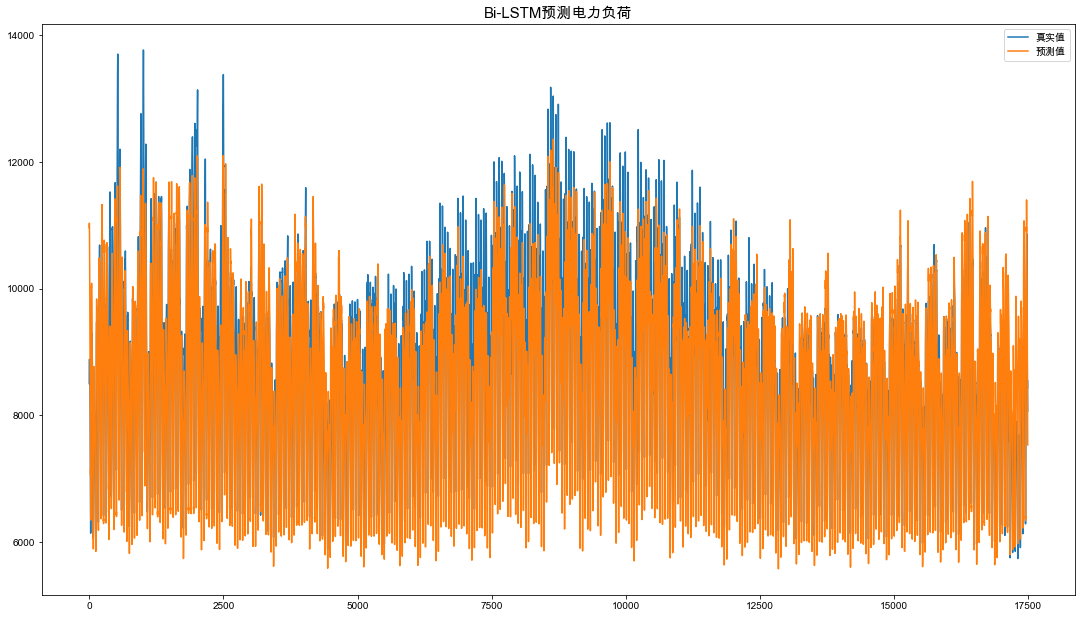

In [55]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]),y_test)#测试数组
plt.plot(np.arange(X_test.shape[0]),pred)#测试数组
plt.legend(['真实值','预测值'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("Bi-LSTM预测电力负荷", fontsize='15',fontweight='bold', color='black')  # 标题
plt.show()

In [56]:
print("mean_absolute_error:", mean_absolute_error(y_test, pred))  
print("rmse:", sqrt(mean_squared_error(y_test, pred)))
print("r2 score:", r2_score(y_test, pred))

mean_absolute_error: 429.9975029745741
rmse: 563.1084529603853
r2 score: 0.8318767665488788


In [ ]:
def build_model(neurons, dropout):
    model = Sequential([
        layers.Conv1D(filters=20, kernel_size=2, input_shape=(n_steps,n_features)),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=10, kernel_size=2),
        layers.MaxPooling1D(2),
        layers.Bidirectional(LSTM(units = neurons,return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(GRU(75, return_sequences=True )),
        layers.Dropout(dropout),
        layers.SimpleRNN(50, activation = 'relu'),
        layers.Dropout(dropout),
        layers.Dense(40, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='linear')    # 因为只有一个特征值的输出
    ])
    return model


def training(X):
    neurons = int(X[0])
    dropout = round(X[1], 6)
    batch_size = int(X[2])
    model = build_model(neurons, dropout)
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=256,
        validation_data=(X_test, y_test),
        verbose=1,shuffle=True)
    model.save(
        'neurons' + str(int(X[0])) + '_dropout' + str(dropout) + '_batch_size' + str(batch_size) + '.h5')

    pred = model.predict(X_test)
    le = len(pred)
    y_t = y_test.reshape(-1, 1)
    return pred, le, y_t


def function(ps, test, le):
    ss = sum(((abs(test - ps)) / test) / le)
    return ss

#前两个设置为2
# (1) PSO Parameters
MAX_EPISODES = 2
MAX_EP_STEPS = 2
c1 = 1
c2 = 1
w = 0.5
pN = 1  # 粒子数量

# (2) LSTM Parameters
dim = 3  # 搜索维度
X = np.zeros((pN, dim))  # 所有粒子的位置和速度
V = np.zeros((pN, dim))
pbest = np.zeros((pN, dim))  # 个体经历的最佳位置和全局最佳位置
gbest = np.zeros(dim)
p_fit = np.zeros(pN)  # 每个个体的历史最佳适应值
print(p_fit.shape)
print(p_fit.shape)
t1 = time.time()

'''
神经网络第一层神经元个数： 250-350
dropout比率： 0.03-0.19
batch_size： 64-128
'''
UP = [350, 0.19, 128]
DOWN = [250, 0.03, 64]

# (4) 开始搜索
for i_episode in range(MAX_EPISODES):
    """初始化s"""
    fit = -1e5  # 全局最佳适应值
    # 初始粒子适应度计算
    print("计算初始全局最优")
    for i in range(pN):
        for j in range(dim):
            V[i][j] = random.uniform(0, 1)
            if j == 1:
                X[i][j] = random.uniform(DOWN[j], UP[j])
            else:
                X[i][j] = round(random.randint(DOWN[j], UP[j]), 0)
        pbest[i] = X[i]
        le, pred, y_t = training(X[i])
        NN = 1
        tmp = function(pred, y_t, le)
        p_fit[i] = tmp
        if tmp > fit:
            fit = tmp
            gbest = X[i]
    print("初始全局最优参数：{:}".format(gbest))

    fitness = []  # 适应度函数
    for j in range(MAX_EP_STEPS):
        fit2 = []
        plt.title("第{}次迭代".format(i_episode))
        for i in range(pN):
            le, pred, y_t = training(X[i])
            temp = function(pred, y_t, le)
            fit2.append(temp / 1000)
            if temp > p_fit[i]:  # 更新个体最优
                p_fit[i] = temp
                pbest[i] = X[i]
                if p_fit[i] > fit:  # 更新全局最优
                    gbest = X[i]
                    fit = p_fit[i]
        print("搜索步数：{:}".format(j))
        print("个体最优参数：{:}".format(pbest))
        print("全局最优参数：{:}".format(gbest))
            # [30.          0.14277071 95.        ]
        for i in range(pN):
            V[i] = w * V[i] + c1 * random.uniform(0, 1) * (pbest[i] - X[i]) + c2 * random.uniform(0, 1) * (gbest - X[i])
            ww = 1
            for k in range(dim):
                if DOWN[k] < X[i][k] + V[i][k] < UP[k]:
                    continue
                else:
                    ww = 0
            X[i] = X[i] + V[i] * ww
        fitness.append(fit)

print('Running time: ', time.time() - t1)



(1,)
(1,)
计算初始全局最优
Epoch 1/256


2022-06-13 19:14:13.464067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:13.744760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:13.754330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:13.823190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:13.831150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:14.000008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:14.014299: I tensorflow/core/grappler/optimizers/cust

595/595 [==============================] - ETA: 0s - loss: 9927966.0000 - mae: 2148.8970

2022-06-13 19:14:59.604454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:59.701108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:59.707587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:59.767823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 19:14:59.773533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


595/595 [==============================] - 51s 82ms/step - loss: 9927966.0000 - mae: 2148.8970 - val_loss: 1314421.0000 - val_mae: 896.8954
Epoch 2/256
595/595 [==============================] - 48s 81ms/step - loss: 1002933.2500 - mae: 714.6897 - val_loss: 472663.3438 - val_mae: 510.4414
Epoch 3/256
595/595 [==============================] - 46s 78ms/step - loss: 435194.9375 - mae: 485.9406 - val_loss: 289628.7188 - val_mae: 405.5874
Epoch 4/256
595/595 [==============================] - 46s 78ms/step - loss: 332278.6562 - mae: 424.1058 - val_loss: 655275.0000 - val_mae: 696.3386
Epoch 5/256
595/595 [==============================] - 46s 78ms/step - loss: 305460.4375 - mae: 403.6023 - val_loss: 538386.1250 - val_mae: 613.1325
Epoch 6/256
595/595 [==============================] - 46s 78ms/step - loss: 291487.9375 - mae: 392.3318 - val_loss: 347016.2188 - val_mae: 473.2141
Epoch 7/256
595/595 [==============================] - 46s 78ms/step - loss: 291455.7812 - mae: 392.9219 - val_los

2022-06-13 22:31:38.371183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:38.463528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:38.470215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:38.535808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:38.541638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


初始全局最优参数：[3.10000000e+02 1.23081103e-01 1.18000000e+02]
Epoch 1/256


2022-06-13 22:31:50.147872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:50.493764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:50.503012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:50.629805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:50.637830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:50.850228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:31:50.863710: I tensorflow/core/grappler/optimizers/cust

595/595 [==============================] - ETA: 0s - loss: 9545482.0000 - mae: 2028.1018

2022-06-13 22:32:35.125611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:32:35.229702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:32:35.236360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:32:35.307419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 22:32:35.313190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


595/595 [==============================] - 50s 80ms/step - loss: 9545482.0000 - mae: 2028.1018 - val_loss: 599440.3125 - val_mae: 583.6764
Epoch 2/256
595/595 [==============================] - 46s 77ms/step - loss: 668805.3750 - mae: 608.4385 - val_loss: 440559.4688 - val_mae: 478.2486
Epoch 3/256
595/595 [==============================] - 46s 78ms/step - loss: 412163.4688 - mae: 470.9901 - val_loss: 403842.0938 - val_mae: 490.9572
Epoch 4/256
595/595 [==============================] - 47s 78ms/step - loss: 307180.6250 - mae: 404.4531 - val_loss: 474192.0938 - val_mae: 580.5048
Epoch 5/256
595/595 [==============================] - 46s 77ms/step - loss: 287174.0312 - mae: 390.5630 - val_loss: 292181.5938 - val_mae: 418.7276
Epoch 6/256
595/595 [==============================] - 46s 77ms/step - loss: 282698.4688 - mae: 387.7141 - val_loss: 306976.7500 - val_mae: 436.2782
Epoch 7/256
595/595 [==============================] - 46s 78ms/step - loss: 270869.9688 - mae: 376.8384 - val_loss:

In [67]:
# 训练模型  使用PSO找到的最好的神经元个数
neurons = int(gbest[0])
dropout = gbest[1]
batch_size = int(gbest[2])
model_PSO_BiLSTM_4layers = build_model(neurons, dropout)
model_PSO_BiLSTM_4layers.compile(optimizer='adam',loss='mse',metrics=['mae'])
model_PSO_BiLSTM_4layers.summary()

es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

history = model_PSO_BiLSTM_4layers.fit(X_train, y_train,callbacks = [es],epochs=256,batch_size=batch_size,validation_data=(X_test, y_test),verbose=1,shuffle=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 29, 20)            220       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 14, 20)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 13, 10)            410       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 6, 10)             0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 6, 514)            551008    
_________________________________________________________________
dropout_54 (Dropout)         (None, 6, 514)            0         
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 6, 512)          

2022-06-11 13:38:27.491054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:38:27.957034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:38:27.966764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:38:28.171640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:38:28.185751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:38:28.407712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:38:28.415970: I tensorflow/core/grappler/optimizers/cust

747/747 [==============================] - ETA: 0s - loss: 7555285.5000 - mae: 1667.6440

2022-06-11 13:39:42.393907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:39:42.543323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:39:42.549951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:39:42.686385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:39:42.693055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:39:42.817866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 13:39:42.823635: I tensorflow/core/grappler/optimizers/cust

747/747 [==============================] - 86s 106ms/step - loss: 7555285.5000 - mae: 1667.6440 - val_loss: 700782.4375 - val_mae: 656.5817
Epoch 2/256
747/747 [==============================] - 74s 98ms/step - loss: 470550.6250 - mae: 509.6621 - val_loss: 858319.8125 - val_mae: 814.6318
Epoch 3/256
747/747 [==============================] - 74s 99ms/step - loss: 345006.4688 - mae: 434.3219 - val_loss: 269677.8125 - val_mae: 395.5390
Epoch 4/256
747/747 [==============================] - 74s 99ms/step - loss: 326337.9688 - mae: 420.8577 - val_loss: 389993.5000 - val_mae: 522.8924
Epoch 5/256
747/747 [==============================] - 73s 98ms/step - loss: 289234.5625 - mae: 393.6559 - val_loss: 420631.9375 - val_mae: 550.8328
Epoch 6/256
747/747 [==============================] - 74s 99ms/step - loss: 280605.3438 - mae: 385.2199 - val_loss: 898057.0000 - val_mae: 854.3590
Epoch 7/256
747/747 [==============================] - 73s 98ms/step - loss: 271335.5938 - mae: 376.8867 - val_loss

In [48]:
# 2.59000000e+02 1.49476884e-01 1.26000000e+02
# 2.59000000e+02 1.49476884e-01 1.26000000e+02
# 2.59000000e+02 1.49476884e-01 1.26000000e+02
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

# 118.           0.18356181 104.
# 3.10000000e+02 1.23081103e-01 1.18000000e+02
neurons = int(3.10000000e+02)
dropout = 1.23081103e-01
batch_size = int(1.18000000e+02)
model_PSO_BiLSTM_4layers = build_model(neurons, dropout)
model_PSO_BiLSTM_4layers.compile(optimizer='adam',loss='mse',metrics=['mae'])
model_PSO_BiLSTM_4layers.summary()

history = model_PSO_BiLSTM_4layers.fit(X_train, y_train,callbacks =[es], epochs=256,batch_size=batch_size,validation_data=(X_test, y_test),verbose=1,shuffle=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 29, 20)            220       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 14, 20)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 13, 10)            410       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 6, 10)             0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 6, 620)            796080    
_________________________________________________________________
dropout_28 (Dropout)         (None, 6, 620)            0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 6, 150)           

2022-06-14 09:49:30.468893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:49:30.868743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:49:30.879837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:49:31.128973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:49:31.137672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:49:31.450072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:49:31.463594: I tensorflow/core/grappler/optimizers/cust

595/595 [==============================] - ETA: 0s - loss: 8661118.0000 - mae: 1952.4908

2022-06-14 09:50:15.954105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:50:16.081658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:50:16.088298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:50:16.178475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 09:50:16.188012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


595/595 [==============================] - 54s 81ms/step - loss: 8661118.0000 - mae: 1952.4908 - val_loss: 872760.1250 - val_mae: 721.8766
Epoch 2/256
595/595 [==============================] - 46s 77ms/step - loss: 644253.1875 - mae: 598.4935 - val_loss: 311169.8438 - val_mae: 421.1729
Epoch 3/256
595/595 [==============================] - 46s 77ms/step - loss: 385762.5000 - mae: 460.1850 - val_loss: 306744.4375 - val_mae: 426.2043
Epoch 4/256
595/595 [==============================] - 46s 77ms/step - loss: 354371.3438 - mae: 439.6992 - val_loss: 348415.1875 - val_mae: 473.0491
Epoch 5/256
595/595 [==============================] - 46s 77ms/step - loss: 331226.1250 - mae: 422.7688 - val_loss: 276671.9688 - val_mae: 404.3264
Epoch 6/256
595/595 [==============================] - 46s 77ms/step - loss: 324433.3750 - mae: 419.2681 - val_loss: 338922.3750 - val_mae: 470.1877
Epoch 7/256
595/595 [==============================] - 46s 77ms/step - loss: 315414.6562 - mae: 411.2728 - val_loss:

In [49]:
pred = model_PSO_BiLSTM_4layers.predict(X_test)

2022-06-14 10:23:32.433195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 10:23:32.532154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 10:23:32.538806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 10:23:32.634938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-14 10:23:32.640753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


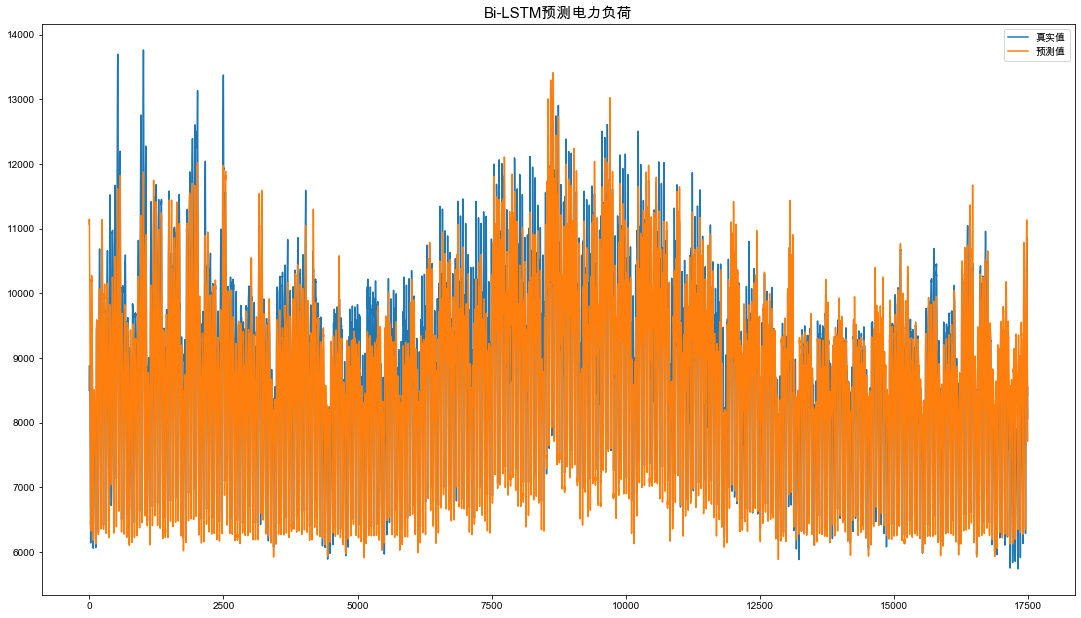

In [50]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]),y_test)#测试数组
plt.plot(np.arange(X_test.shape[0]),pred)#测试数组
plt.legend(['真实值','预测值'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("Bi-LSTM预测电力负荷", fontsize='15',fontweight='bold', color='black')  # 标题
plt.show()

In [51]:
print("mean_absolute_error:", mean_absolute_error(y_test, pred))  
print("rmse:", sqrt(mean_squared_error(y_test, pred)))
print("r2 score:", r2_score(y_test, pred))
print("MAPE:",metrics.mean_absolute_percentage_error(y_test, pred))

mean_absolute_error: 360.6524676682555
rmse: 475.6741032559972
r2 score: 0.880032762922675
MAPE: 0.04065366988938862


In [ ]:
def build_model(neurons, dropout):
    model = Sequential([
        layers.Conv1D(filters=20, kernel_size=2, input_shape=(n_steps,n_features)),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=10, kernel_size=2),
        layers.MaxPooling1D(2),
        layers.Bidirectional(LSTM(units = neurons,return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(LSTM(units = 100,return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(GRU(75, return_sequences=True )),
        layers.Dropout(dropout),
        layers.SimpleRNN(50, activation = 'relu'),
        layers.Dropout(dropout),
        layers.Dense(40, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='linear')    # 因为只有一个特征值的输出
    ])
    return model


def training(X):
    neurons = int(X[0])
    dropout = round(X[1], 6)
    batch_size = int(X[2])
    model = build_model(neurons, dropout)
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=256,
        validation_data=(X_test, y_test),
        verbose=1,shuffle=True)
    model.save(
        'neurons' + str(int(X[0])) + '_dropout' + str(dropout) + '_batch_size' + str(batch_size) + '.h5')

    pred = model.predict(X_test)
    le = len(pred)
    y_t = y_test.reshape(-1, 1)
    return pred, le, y_t


def function(ps, test, le):
    ss = sum(((abs(test - ps)) / test) / le)
    return ss

#前两个设置为2
# (1) PSO Parameters
MAX_EPISODES = 2
MAX_EP_STEPS = 2
c1 = 1
c2 = 1
w = 0.5
pN = 1  # 粒子数量

# (2) LSTM Parameters
dim = 3  # 搜索维度
X = np.zeros((pN, dim))  # 所有粒子的位置和速度
V = np.zeros((pN, dim))
pbest = np.zeros((pN, dim))  # 个体经历的最佳位置和全局最佳位置
gbest = np.zeros(dim)
p_fit = np.zeros(pN)  # 每个个体的历史最佳适应值
print(p_fit.shape)
print(p_fit.shape)
t1 = time.time()

'''
神经网络第一层神经元个数： 150-256
dropout比率： 0.03-0.19
batch_size： 64-128
'''
UP = [256, 0.19, 128]
DOWN = [150, 0.03, 64]

# (4) 开始搜索
for i_episode in range(MAX_EPISODES):
    """初始化s"""
    fit = -1e5  # 全局最佳适应值
    # 初始粒子适应度计算
    print("计算初始全局最优")
    for i in range(pN):
        for j in range(dim):
            V[i][j] = random.uniform(0, 1)
            if j == 1:
                X[i][j] = random.uniform(DOWN[j], UP[j])
            else:
                X[i][j] = round(random.randint(DOWN[j], UP[j]), 0)
        pbest[i] = X[i]
        le, pred, y_t = training(X[i])
        NN = 1
        tmp = function(pred, y_t, le)
        p_fit[i] = tmp
        if tmp > fit:
            fit = tmp
            gbest = X[i]
    print("初始全局最优参数：{:}".format(gbest))

    fitness = []  # 适应度函数
    for j in range(MAX_EP_STEPS):
        fit2 = []
        plt.title("第{}次迭代".format(i_episode))
        for i in range(pN):
            le, pred, y_t = training(X[i])
            temp = function(pred, y_t, le)
            fit2.append(temp / 1000)
            if temp > p_fit[i]:  # 更新个体最优
                p_fit[i] = temp
                pbest[i] = X[i]
                if p_fit[i] > fit:  # 更新全局最优
                    gbest = X[i]
                    fit = p_fit[i]
        print("搜索步数：{:}".format(j))
        print("个体最优参数：{:}".format(pbest))
        print("全局最优参数：{:}".format(gbest))
            # [30.          0.14277071 95.        ]
        for i in range(pN):
            V[i] = w * V[i] + c1 * random.uniform(0, 1) * (pbest[i] - X[i]) + c2 * random.uniform(0, 1) * (gbest - X[i])
            ww = 1
            for k in range(dim):
                if DOWN[k] < X[i][k] + V[i][k] < UP[k]:
                    continue
                else:
                    ww = 0
            X[i] = X[i] + V[i] * ww
        fitness.append(fit)

print('Running time: ', time.time() - t1)




(1,)
(1,)
计算初始全局最优
Epoch 1/256


2022-06-11 17:12:04.950240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:12:05.426043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:12:05.436695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:12:05.624652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:12:05.634828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:12:05.806411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:12:05.814463: I tensorflow/core/grappler/optimizers/cust

975/975 [==============================] - ETA: 0s - loss: 6845859.0000 - mae: 1524.2216

2022-06-11 17:13:35.818649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:13:35.962354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:13:35.968919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:13:36.103909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:13:36.111963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:13:36.252092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 17:13:36.257822: I tensorflow/core/grappler/optimizers/cust

975/975 [==============================] - 101s 99ms/step - loss: 6845859.0000 - mae: 1524.2216 - val_loss: 364690.6562 - val_mae: 480.8387
Epoch 2/256
975/975 [==============================] - 90s 92ms/step - loss: 339505.1562 - mae: 428.0519 - val_loss: 421607.1875 - val_mae: 516.3669
Epoch 3/256
975/975 [==============================] - 90s 92ms/step - loss: 299803.3750 - mae: 398.2872 - val_loss: 342762.1250 - val_mae: 439.9418
Epoch 4/256
975/975 [==============================] - 89s 92ms/step - loss: 315902.9375 - mae: 409.5533 - val_loss: 218042.6250 - val_mae: 338.5451
Epoch 5/256
975/975 [==============================] - 89s 92ms/step - loss: 305245.8750 - mae: 404.0249 - val_loss: 230235.7188 - val_mae: 360.6062
Epoch 6/256
975/975 [==============================] - 89s 92ms/step - loss: 278052.0625 - mae: 381.3826 - val_loss: 195141.1250 - val_mae: 317.4681
Epoch 7/256
975/975 [==============================] - 89s 92ms/step - loss: 276161.8125 - mae: 380.0554 - val_loss

In [46]:
def build_model(neurons, dropout):
    model = Sequential([
        layers.Conv1D(filters=20, kernel_size=2, input_shape=(n_steps,n_features)),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=10, kernel_size=2),
        layers.MaxPooling1D(2),
        layers.Bidirectional(LSTM(units = neurons,return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(LSTM(units = 100,return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(GRU(75, return_sequences=True )),
        layers.Dropout(dropout),
        layers.SimpleRNN(50, activation = 'relu'),
        layers.Dropout(dropout),
        layers.Dense(40, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='linear')    # 因为只有一个特征值的输出
    ])
    return model


def training(X):
    neurons = int(X[0])
    dropout = round(X[1], 6)
    batch_size = int(X[2])
    model = build_model(neurons, dropout)
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=256,
        validation_data=(X_test, y_test),
        verbose=1,shuffle=True)
    model.save(
        'neurons' + str(int(X[0])) + '_dropout' + str(dropout) + '_batch_size' + str(batch_size) + '.h5')

    pred = model.predict(X_test)
    le = len(pred)
    y_t = y_test.reshape(-1, 1)
    return pred, le, y_t


def function(ps, test, le):
    ss = sum(((abs(test - ps)) / test) / le)
    return ss

In [47]:
# 2.59000000e+02 1.49476884e-01 1.26000000e+02
# 2.59000000e+02 1.49476884e-01 1.26000000e+02
# 2.59000000e+02 1.49476884e-01 1.26000000e+02
# 2.34000000e+02 7.25324749e-02 7.20000000e+01
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

neurons = int(2.34000000e+02)
dropout = 7.25324749e-02
batch_size = int(7.20000000e+01)
model_PSO_BiLSTM_4layers = build_model(neurons, dropout)
model_PSO_BiLSTM_4layers.compile(optimizer='adam',loss='mse',metrics=['mae'])
model_PSO_BiLSTM_4layers.summary()

history = model_PSO_BiLSTM_4layers.fit(X_train, y_train,callbacks = [es],epochs=256,batch_size=batch_size,validation_data=(X_test, y_test),verbose=1,shuffle=True)

Metal device set to: Apple M1 Pro


2022-06-12 10:21:05.729587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 10:21:05.729748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 20)            220       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 10)            410       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 10)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 468)            458640    
_________________________________________________________________
dropout (Dropout)            (None, 6, 468)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6, 200)            4

2022-06-12 10:21:06.307253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-12 10:21:06.307715: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-12 10:21:08.348044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:21:08.757841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:21:08.767161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:21:08.843311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:21:08.852741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

  1/975 [..............................] - ETA: 50:48 - loss: 78903320.0000 - mae: 8759.6680

2022-06-12 10:21:09.329978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:21:09.347195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


975/975 [==============================] - ETA: 0s - loss: 7450740.0000 - mae: 1763.6177

2022-06-12 10:22:41.707739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:22:41.836833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:22:41.843645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:22:41.894817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:22:41.901875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:22:41.950788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 10:22:41.956246: I tensorflow/core/grappler/optimizers/cust

975/975 [==============================] - 103s 103ms/step - loss: 7450740.0000 - mae: 1763.6177 - val_loss: 1091254.0000 - val_mae: 808.3743
Epoch 2/256
975/975 [==============================] - 94s 97ms/step - loss: 611524.5625 - mae: 584.2563 - val_loss: 1048360.5000 - val_mae: 839.4703
Epoch 3/256
975/975 [==============================] - 94s 96ms/step - loss: 529092.5000 - mae: 536.3931 - val_loss: 271089.2188 - val_mae: 376.3542
Epoch 4/256
975/975 [==============================] - 92s 94ms/step - loss: 331661.7188 - mae: 422.9913 - val_loss: 255914.1562 - val_mae: 371.0583
Epoch 5/256
975/975 [==============================] - 92s 94ms/step - loss: 322421.5938 - mae: 416.4427 - val_loss: 243059.5938 - val_mae: 363.6465
Epoch 6/256
975/975 [==============================] - 91s 94ms/step - loss: 301460.9688 - mae: 398.7741 - val_loss: 268833.5938 - val_mae: 396.6533
Epoch 7/256
975/975 [==============================] - 87s 89ms/step - loss: 302982.3438 - mae: 398.1743 - val_l

In [48]:
pred = model_PSO_BiLSTM_4layers.predict(X_test)

2022-06-12 11:11:38.862268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 11:11:38.979382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 11:11:38.986858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 11:11:39.043521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 11:11:39.050225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 11:11:39.104285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-12 11:11:39.110311: I tensorflow/core/grappler/optimizers/cust

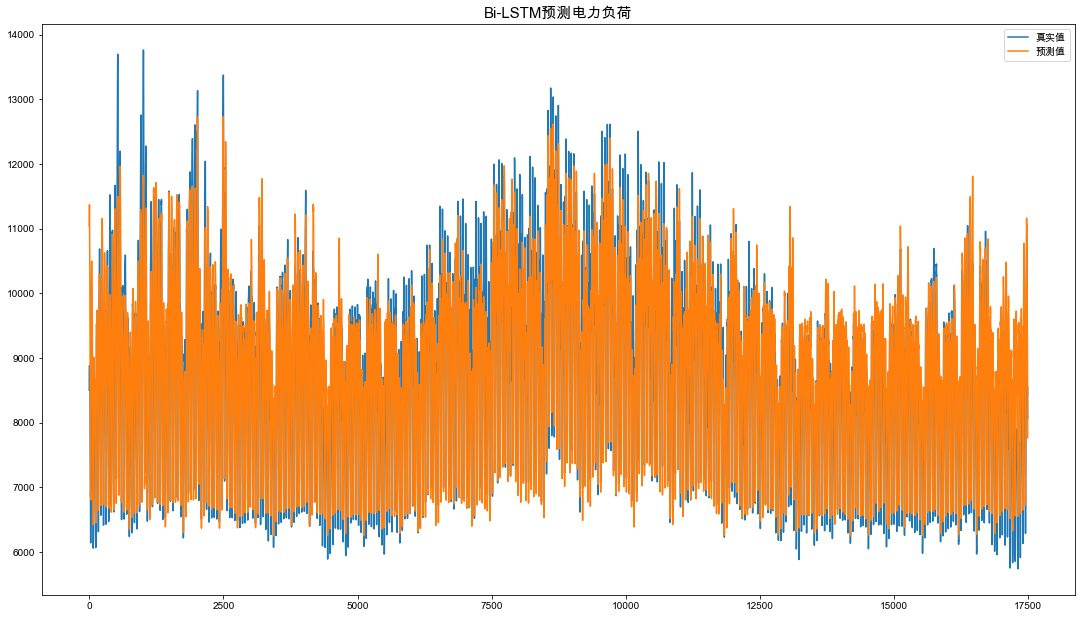

In [49]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]),y_test)#测试数组
plt.plot(np.arange(X_test.shape[0]),pred)#测试数组
plt.legend(['真实值','预测值'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("Bi-LSTM预测电力负荷", fontsize='15',fontweight='bold', color='black')  # 标题
plt.show()

In [50]:
print("mean_absolute_error:", mean_absolute_error(y_test, pred))  
print("rmse:", sqrt(mean_squared_error(y_test, pred)))
print("r2 score:", r2_score(y_test, pred))
print("MAPE:",metrics.mean_absolute_percentage_error(y_test, pred))

mean_absolute_error: 335.764476544188
rmse: 459.5392252596206
r2 score: 0.8880333160632259
MAPE: 0.03817987730892328
